# Stock Pitch and Trading Simulation
---
Final Project

Name: Kehang Zhou (kz653@nyu.edu)

Date: May 8, 2017

### Introduction:
Stock Pitch has long been a popular topic among investors, either speculative or long-term. People always want to invest in a stock which could bring them gigantic and stable wealth. Fundamental analysis and technical analysis are the two main analysis branch in the equity market. Technical analysis approaches security from the chart and historical performance, while fundamental analysis approaches security from company's financial statements statistics. 

This project is totally an exploration which aims to explore both of these two analysis and apply them in pitching stocks. I tried to explore the relationships between returns of stocks and statistics of stocks I got(both statistics of company and stock performance). I also approach the analysis from multiple dimensions besides statistics(sectors, trading volumes). In the final part, I tried to do 2 trading simulations(Back test) on specific strategies to see if we can turn our analysis to profitable trading ideas.

### Outline:

* Process of Deriving Data and Simple Data Cleaning (skippable and Unstable)
* Data Analysis on Statistics
* Trading Simulation and Analysis

Note that the first part is skippable. Also please don't run the cells simultaneously. The main parts of this notebook is based on the customized dataset I derived on April 15th. Please load the `csv` file in the Data Analysis part.


In [1]:
import requests
import sys                             # system module 
import pandas as pd                    # data package
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt        # graphics module  
import datetime as dt                  # date and time module
import numpy as np                     # foundation for pandas 
       
import seaborn as sns                  # seaborn graphic tools

from plotly.offline import iplot, iplot_mpl  # plotly plotting functions
import plotly.graph_objs as go               
import plotly                                

import statsmodels.formula.api as sm    #linear regression package
import statsmodels.api as sm
from pandas.stats.api import ols
%matplotlib inline             
plotly.offline.init_notebook_mode(connected=True)

### Main Dataset
I found the list of S&P 500 companies dataset in the [website](http://data.okfn.org/data/core/s-and-p-500-companies/) . The file `constituents-financial.csv` contains symbol of the company, name of the company, sector of the company and a bunch of financial statistics about the companies such as dividend yield, price to books value and EBITDA. Those could be useful to me but I’m afraid that those are not the most up-to-date statistics. So I use another file `constituents.csv` which only contains symbols, names and sectors. 

In [2]:
#read the data from github and use the second file
url = 'https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents-financials.csv'
url2 = 'https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv'
sp = pd.read_csv(url2)

In [3]:
# The table looks like:
sp.head(8)

,Symbol,Name,Sector
0,MMM,3M Company,Industrials
1,ABT,Abbott Laboratories,Health Care
2,ABBV,AbbVie,Health Care
3,ACN,Accenture plc,Information Technology
4,ATVI,Activision Blizzard,Information Technology
5,AYI,Acuity Brands Inc,Industrials
6,ADBE,Adobe Systems Inc,Information Technology
7,AAP,Advance Auto Parts,Consumer Discretionary


In [4]:
sp.shape        #general shape of the dataset

(505, 3)

In [5]:
sp.dtypes       #datatypes of the dataset

Symbol    object
Name      object
Sector    object
dtype: object

### Yahoo Finance Data Package
Here I Install Yahoo finance package in order to get access to latest stock data:

Please use `pip install yahoo-finance` in commander to intall the package

According to the python index [instruction](https://pypi.python.org/pypi/yahoo-finance). I used multiple methods to get data by passing through the symbol of the stock.

Basically, this package could give you the latest statistics of companies and stocks in the Yahoo-finance summary page of a stock. Here is an example of the [page](https://finance.yahoo.com/quote/AAPL/key-statistics?p=AAPL)

In [6]:
from yahoo_finance import Share                        #load the Share funciton 

In [7]:
#Example: By putting an authorized symbol of stock in the share function, we could get the statsitics we want. 
#Below is demo to get the 50day_moving_average of BRK-B share.
Share('BRK-B').get_50day_moving_avg()       

'166.89'

In [8]:
stocklist = list(sp['Symbol'].astype(str))    #get the symbol list with symbols as string
print(len(stocklist))
stocklist[0:5]                                # How the string

505


['MMM', 'ABT', 'ABBV', 'ACN', 'ATVI']

I discover that in our stocklist. Some symbol such as `BRK.B` contains a dot '.' . Yahoo Finance package only accepts symbol with '-' like `BRK-B`. So I cleaned the data by replacing '.' with '-'.  

In [9]:
stocklist_a = []                                           # create a adjusted list of symbol
for stock in stocklist:
    slist = list(stock)                                    # use list function on a string
    slist2 = ['-' if x=='.' else x for x in slist]        # replace the '.' in the list with '-'  
    stock = "".join(slist2)                               # combine the list as a string
    stocklist_a.append(stock)                             # put the new symbol in the new list
sp['Symbol'] = stocklist_a                                #set the adjusted list as symbols in data

In [10]:
print(stocklist_a[0:10])                                  # how the adjusted list looks like
sp.head(7)

['MMM', 'ABT', 'ABBV', 'ACN', 'ATVI', 'AYI', 'ADBE', 'AAP', 'AES', 'AET']


,Symbol,Name,Sector
0,MMM,3M Company,Industrials
1,ABT,Abbott Laboratories,Health Care
2,ABBV,AbbVie,Health Care
3,ACN,Accenture plc,Information Technology
4,ATVI,Activision Blizzard,Information Technology
5,AYI,Acuity Brands Inc,Industrials
6,ADBE,Adobe Systems Inc,Information Technology


* Then I used the `for` loop to get the specific statistics for each stock. Put all data in a list and then put the list in the dataframe 

`get_50day_moving_avg()`  - get the 50 days moving average of the stock price

`get_200day_moving_avg()` - get the 200 days moving average of the stock price

`get_dividend_yield()`    - get the dividend yield of the stock 

`get_short_ratio()`      - get the short ratio of the stock

`get_price_earnings_growth_ratio()` -get the price to earning growth ratio(Peg) of the stock

I passed each one separately. Because every time I put the code together in one, it takes a super long time and it will have a error message. It's better if we run each one separately. 

* **Warning: When I use the code to derive my dataset on April 15, 2016, everything was fine. However, when I execute the code in May, I always get error message saying `HTTP error` and the `for` loop interrupt. So if you run the cell below and get a error message, please don't executes the rest cells in the first part and just read the first part (Otherwise you'll get a lot error message). That's also why I clear the output of the dataset ** 

In [11]:
list1 = []                                                                 # create an empty list to fill in the statistics.
for s in stocklist_a:                                                      # use the for loop to pass every symbol through
    a = Share(s).get_50day_moving_avg()
    list1.append(a)

HTTPError: HTTP Error 500: Server Error

In [12]:
list1[0:5]                                        # How the list would look like if no error

['192.36', '44.09', '65.30', '119.5790', '50.10']

In [ ]:
sp['50 Days Moving Average'] = list1              # create a new columns and put the list 
sp.head(5)

In [ ]:
#The following codes did the similar things.
list2 = []
for s1 in stocklist_a:
    list2.append(Share(s1).get_200day_moving_avg())                  

In [ ]:
list3 = []
for s2 in stocklist_a:
    list3.append(Share(s2).get_dividend_yield())

In [ ]:
list4 = []
for s3 in stocklist_a:
    list4.append(Share(s3).get_short_ratio())

In [130]:
list5 = []
for s4 in stocklist_a:
    list5.append(Share(s4).get_price_earnings_growth_ratio())

In [131]:
sp['200 Days Moving Average'] = list2
sp['Dividend Yield'] = list3
sp['Short Ratio'] = list4
sp['Peg Ratio'] = list5

#### Get the holding period return data from November 1 2016 to April 15 2017 by using the **pandas data reader**
The reasons why I pick the time range from November 1,2016 to Aril 15, 2017 are: 
1. It is roughly 6 month, half year. 
2. Some statistics of companies like oeg ratio doesn't change frequently but seasonally or semi-annually according to their report. So the statistics we get should have effects on the stock price during the period.
3. US stock market has experienced a huge rally after the US presidency election on the start of November 2016.


In [ ]:
# create two list for the stock price on the first day and the stock price on the last day
startlist=[]
closelist=[]
for stock in stocklist_a:
    start = datetime.datetime(2016, 11, 1)
    end = datetime.datetime(2017, 4, 15)
    f = web.DataReader(stock, 'yahoo', start, end)        
    flist = f['Close'].tolist()                      #put the close price in the list
    startlist.append(flist[0])                       # add the close price on the first day to the startlist
    closelist.append(flist[-1])                      # add the close price on the last day to the startlist
    

In [ ]:
sp['Stock price on 2016-11-1'] = startlist           # set new columns to put two lists in as data
sp['Stock price on 2017-4-15'] = closelist
sp['Holding Period Return'] = sp['Stock price on 2017-4-15']/sp['Stock price on 2016-11-1'] -1   
# Calculate Holding period return data in this period and put it in to the dataset as a new column
sp.head()

Since every time I passed on the code I would get latest data from Yahoo Finance. SO I save the data derived on April 15 to csv file and load it again


In [22]:
#sp.to_csv('sp500_April_15.csv')                                          # Save the data to our computer, please don't pass

# Data Analysis on Statistics 
## Main parts  start from Here
Please load the dataset `sp500_April_15.csv` from the computer, you could replace the code in the cell below to read the csv file from certain path, I put the csv in the same path of this jupyter notebook.

In [14]:
spd = pd.read_csv('sp500_April_15.csv',                #the data derived on April 15th.
                 usecols = range(1,12))                # The first column became number automatically and we don't want it

In [15]:
spd.head()                                             # general look of the data set

,Symbol,Name,Sector,50 Days Moving Average,200 Days Moving Average,Dividend Yield,Short Ratio,Peg Ratio,Stock price on 2016-11-1,Stock price on 2017-4-15,Holding Period Return
0,MMM,3M Company,Industrials,190.17,178.69,2.49,4.03,2.46,164.250000,188.649994,0.148554
1,ABT,Abbott Laboratories,Health Care,44.76,41.60,2.48,1.65,1.59,39.049999,42.669998,0.092702
2,ABBV,AbbVie,Health Care,64.69,62.20,3.99,4.90,0.80,56.450001,64.129997,0.136050
3,ACN,Accenture plc,Information Technology,121.49,118.87,2.11,4.22,2.08,116.139999,114.860001,-0.011021
4,ATVI,Activision Blizzard,Information Technology,48.50,42.49,0.62,2.58,1.54,42.599998,48.419998,0.136620


# Stock pitch by sectors 
### Stock data in specific sector

In [16]:
# spdi is our main dataset, but I also created some other dataset.
spdi = spd.set_index(['Symbol','Name'])  # set the multi-level index
spdi.head()

,,Sector,50 Days Moving Average,200 Days Moving Average,Dividend Yield,Short Ratio,Peg Ratio,Stock price on 2016-11-1,Stock price on 2017-4-15,Holding Period Return
Symbol,Name,,,,,,,,,
MMM,3M Company,Industrials,190.17,178.69,2.49,4.03,2.46,164.250000,188.649994,0.148554
ABT,Abbott Laboratories,Health Care,44.76,41.60,2.48,1.65,1.59,39.049999,42.669998,0.092702
ABBV,AbbVie,Health Care,64.69,62.20,3.99,4.90,0.80,56.450001,64.129997,0.136050
ACN,Accenture plc,Information Technology,121.49,118.87,2.11,4.22,2.08,116.139999,114.860001,-0.011021
ATVI,Activision Blizzard,Information Technology,48.50,42.49,0.62,2.58,1.54,42.599998,48.419998,0.136620


In [17]:
spdi['Sector'].value_counts()    # count how many companies in each sector

Consumer Discretionary         86
Information Technology         68
Industrials                    66
Financials                     65
Health Care                    60
Consumer Staples               37
Energy                         35
Real Estate                    30
Utilities                      28
Materials                      25
Telecommunications Services     5
Name: Sector, dtype: int64

In [18]:
sector = list(spdi['Sector'].unique())    # find all the sectors name by using the unique function and put into list
sector

['Industrials',
 'Health Care',
 'Information Technology',
 'Consumer Discretionary',
 'Utilities',
 'Financials',
 'Materials',
 'Consumer Staples',
 'Real Estate',
 'Energy',
 'Telecommunications Services']

In [19]:
dic = dict(spdi['Sector'].value_counts())           # use the dict function to make the value_counts a dictionary
sector_name = [key for key in dic.keys()]           # the key of the dictionary is name of each sector, put into a list
sector_count = [v for v in dic.values()]            # the value of the dictionary is numbers of companies in each sector, put in a list 

# Use the plotly to visualize the composition of S&P 500 stocks, use pie plot
fig = {
    'data': [{'labels': sector_name,
              'values': sector_count,
              'type': 'pie', 
              'hoverinfo':'label+percent+value',
             'hole' : .4
             }],
    'layout': {'title': 'S&P500 Decomposition by Sector Pie Chart',
              'annotations':[{
                'font': {'size': 10},
                'showarrow': False,
                'text': 'Sector + # of Companies + Percentage',
                'x': 0.5,
                'y': 0.5
            }]
     }
}
iplot(fig)

#### Comment:
The S&P 500 contains companies from 11 sectors. Companies are distributed in these 11 sectors. But some sectors like Telecom and Material only contains a relative small amount of companies. 

Below is simple bar plot to see the holding period return of companies inside 'Industrial' Sectors

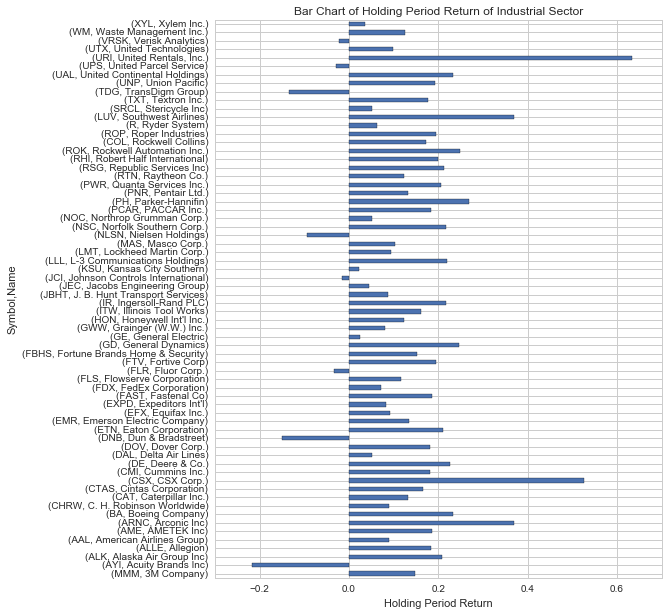

In [20]:
sns.set_style("whitegrid")                                # set the seaborn plotting style
# first try, simple bar plot example
spd1 = spdi[spdi['Sector']== sector[0]]                   # a small subset spd1 by slicing
fig, ax = plt.subplots(figsize=(8, 10))
spd1['Holding Period Return'].plot.barh(ax=ax)
ax.set_title('Bar Chart of Holding Period Return of Industrial Sector')
ax.set_xlabel('Holding Period Return')

Below is the plot procedure of average holding period return for each sector. We also add a horizontal line to show the holding period return on the S&P 500 index. By doing that, we could see which sector outperforms the aggregate index. 

Note that the symbol for S&P500 index in Yahoo finance is '^GSPC'

The Holding Period Return for S&P500 index is 0.102868743481


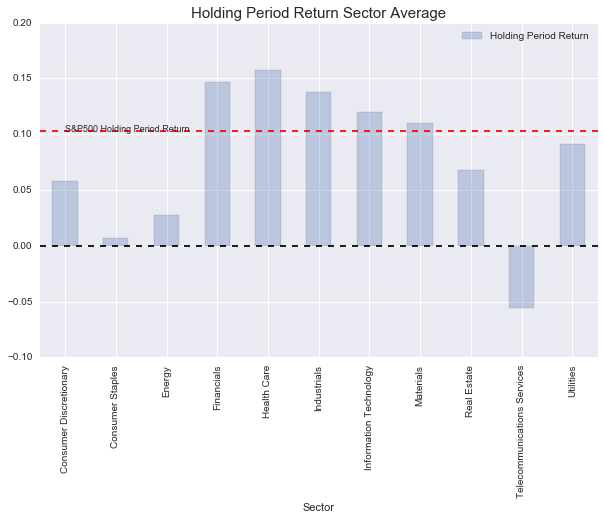

In [21]:
sns.set()                                                            # reset the seaborn plotting style to default

# The following paragraph shows us how to get the holding period return of S&P 500 index. 
start = datetime.datetime(2016, 11, 1)
end = datetime.datetime(2017, 4, 15)
sp500 = web.DataReader('^GSPC', 'yahoo', start, end)                   # sp500 is a dataset used to calculate the return of the index
sp500_price = sp500['Close'].tolist()
sp500_return = sp500_price[-1] / sp500_price[0] -1
print('The Holding Period Return for S&P500 index is',sp500_return)

# The following codes shows how to plot
ave = spdi['Holding Period Return'].groupby(spdi['Sector']).mean()      # Use the groupby method to get the mean HPR
ave = ave.reset_index()
ave = ave.set_index('Sector')                                           # reset and then set the 'Sector' as index
# plot
fig, ax = plt.subplots(figsize = (10,6))
ave.plot(ax = ax, kind='bar',alpha = 0.3)
ax.axhline(sp500_return, linestyle = 'dashed', color = 'red')
ax.axhline(0,linestyle = '--', color ='black')
ax.set_title('Holding Period Return Sector Average', fontsize=15)
ax.text(0,sp500_return,'S&P500 Holding Period Return', fontsize=9)

#### Comment:
From the plot, we could see that there are five sectors outperform the index(Financials, Health Care, Industrials, Information Technology, Materials) over the last half year.The only one sector that suffered from losses is the Telecom sector with least amount of companies.Consumer Staples and Energy Sectors also performs badly. So we might avoid bad sectors and pick good sectors in the following pitch.

### Dividend Yield Pattern of Sectors
Here is graph of both boxplot and swarmplot of dividend yield of companies, classified by sectors in one canvas.

Before the plot, I have some comprehension of dividend yield. Dividend Yield, according to the definition, is a dividend expressed as a percentage of a current share price.

The companies with high profitability should have more disposable cash flow, so the dividend yield should be higher for them. Companies (such as tech companies and health care companies) which need a lot capital should be capital intensive and pay little dividend. But how big it is should also depend on company's operation strategy.

If a company pays a lot of dividend, of course shareholder would be happy because of the capital gain. It might attract a lot of new shareholders so the share price could go up. Return of the stock should also go up. But in the other hand, paying dividend unwisely could reduce company's disposable cash flow so the profitability should go down. This would cause negative effect on the stock price.

Let's see if we can capture the pattern of dividend yield of each sector.

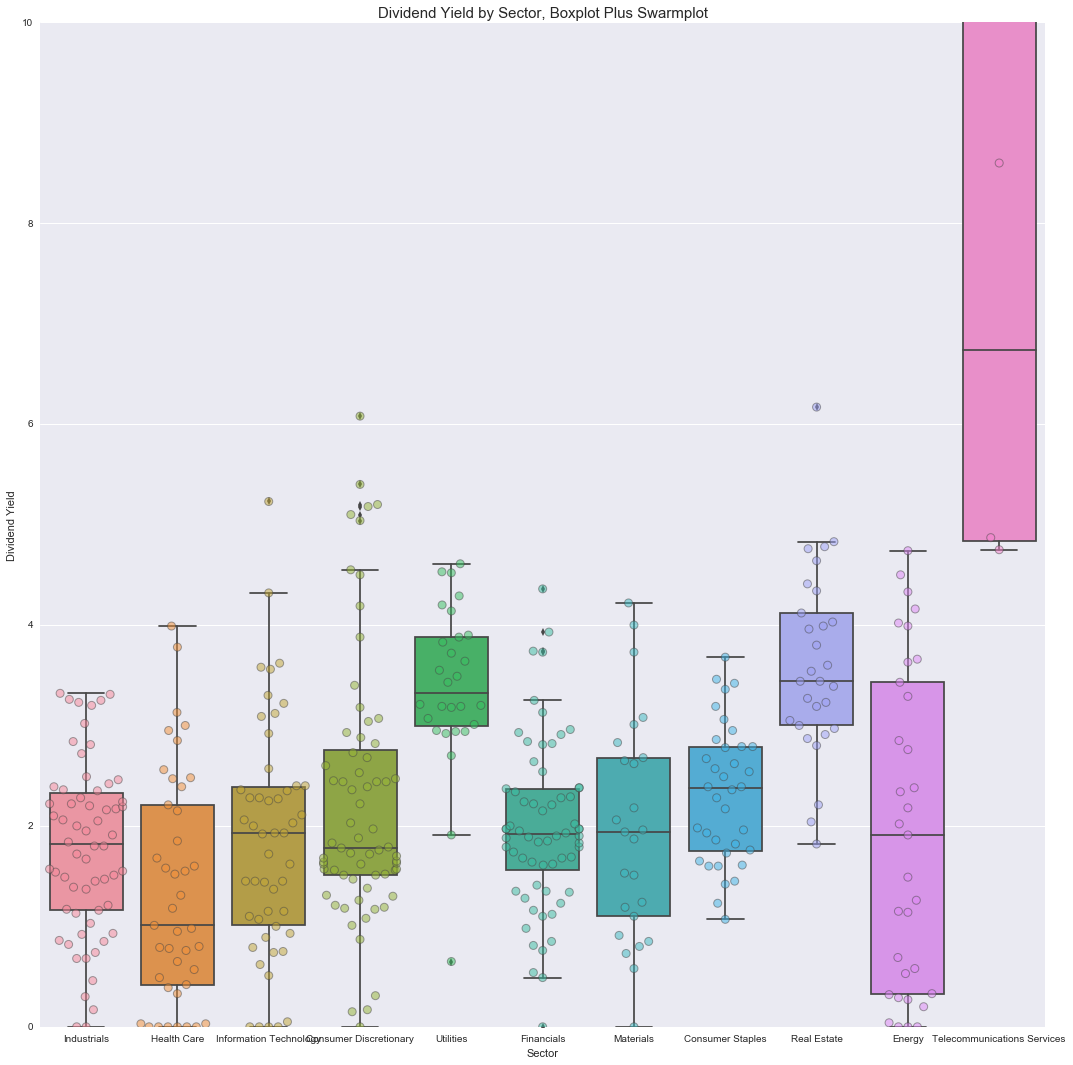

In [22]:
# seaborn boxplot and swarmplot
fig,ax = plt.subplots(figsize=(18,18))
sns.boxplot(ax=ax,data=spdi, x='Sector', y='Dividend Yield')
sns.swarmplot(ax=ax,data=spdi, x='Sector', y='Dividend Yield',size =8, linewidth=1, alpha=0.5)
ax.set_ylim([0,10])
ax.set_title('Dividend Yield by Sector, Boxplot Plus Swarmplot', fontsize = 15)

#### Comment:
There are some notable facts in this graph.
1. Inside each sector, companies could have very different dividend yield even if they are in the same sector. Energy group is a good example for this point. The range of the dividend yield is wide.
2. There are some sectors which have high dividend yield in average. Utility and Real Estate sectors are two that have relatively high dividend yield. The only 5 companies in Telecom sector all pay super high dividend and they have really bad average holding period return. If we relate these with sector average holding period return above, the high dividend yield could be the reason why these sectors have underperformed the index and other sectors. 
3. The sectors(Financials, Health Care, Industrials, Information Technology) which have outperformed the index all have relativlely low dividend yield in average. Take Health Care sector as an example. It has lowest average dividend yield(some health care companies don't pay dividend yield at all!). But it has highest average holding period return. 


### Data Analysis on all Statistics - Explore the correlation
I've already introduced the dividend yield. There are still some other statistics in the chart.

Definitions：
[PEG Ratio](https://en.wikipedia.org/wiki/PEG_ratio)
[Short Ratio](https://en.wikipedia.org/wiki/Short_interest_ratio)
[Moving Average](http://www.investopedia.com/terms/m/movingaverage.asp)
* The Peg Ratio is a valuation metric for determining the relative trade-off between the price of a stock, the earnings generated per share (EPS), and the company's expected growth. It is derived by dividing the Price to earning ratio by the growth rate of earnings per share. High PEG ratio indicate that the company is overvalued too much compare to its growth, while a super low peg ratio might indicate that the company is undervalued. It could also be negative because the earnings and it's growth could be negative. A fair Peg raito should be around 1.

* The short ratio is the ratio of tradable shares being shorted to shares in the market. Shorting stocks means that the investors is not optimistic about the stock. So I think a stock with relatively high short ratio should have lower return

* Moving Average is a techinical analysis tool on the stock price. I used the simple moving average of stock price over last several days as the moving average. Usually, when the short term moving average is above the long term moving average, the stock should perform well. 

In below, I add a column of 'sector average return' on the main dataset spdi. I also created a subset named sp_outperform by slicing the companies which outperform the sector average return. I use this dataset to do the data analysis, which gives me better and more visible  correlation in below

In [23]:
# create subset of outperforming companies
spdi['Sector Average Return'] = spdi['Holding Period Return'].groupby(spdi['Sector']).transform('mean')
sp_outperform = spdi[spdi['Holding Period Return'] > spdi['Sector Average Return']]
sp_outperform.head()

,,Sector,50 Days Moving Average,200 Days Moving Average,Dividend Yield,Short Ratio,Peg Ratio,Stock price on 2016-11-1,Stock price on 2017-4-15,Holding Period Return,Sector Average Return
Symbol,Name,,,,,,,,,,
MMM,3M Company,Industrials,190.17,178.69,2.49,4.03,2.46,164.250000,188.649994,0.148554,0.138182
ATVI,Activision Blizzard,Information Technology,48.50,42.49,0.62,2.58,1.54,42.599998,48.419998,0.136620,0.120163
ADBE,Adobe Systems Inc,Information Technology,124.94,112.64,0.00,2.25,2.03,106.870003,129.050003,0.207542,0.120163
AET,Aetna Inc,Health Care,129.54,122.75,1.55,4.42,1.09,105.820000,128.630005,0.215555,0.157534
AMG,Affiliated Managers Group Inc,Financials,163.76,151.95,0.49,2.48,0.78,134.339996,161.279999,0.200536,0.146524


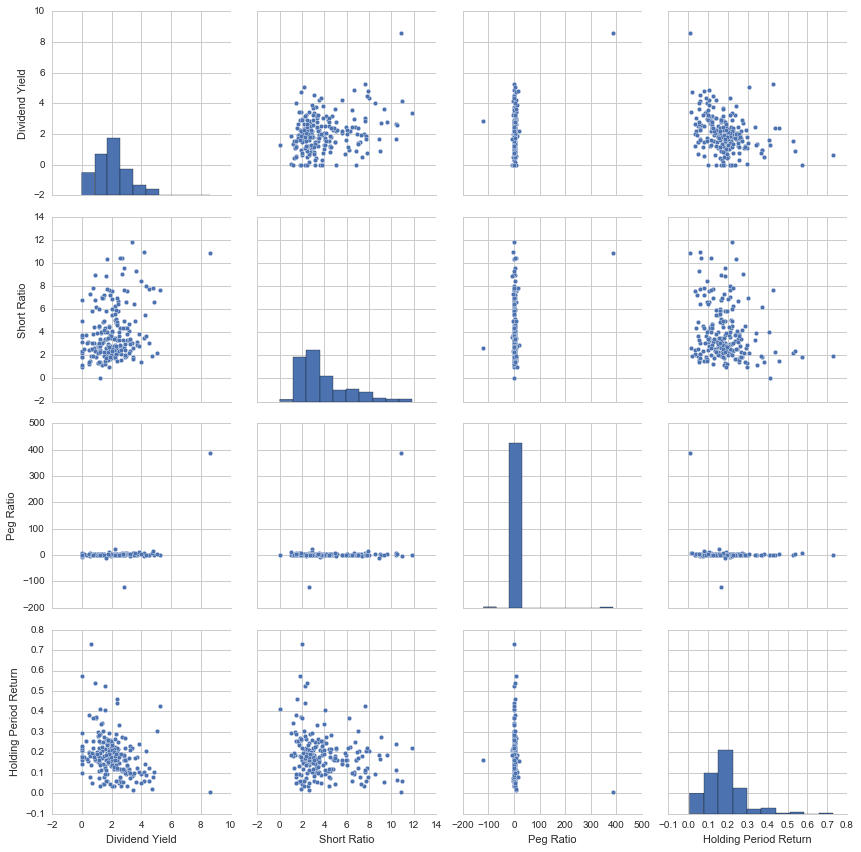

In [24]:
#Use the seaborn pairplot to give a overview of the statistics and the holding period return
sns.set_style("whitegrid")
sp_outperform = sp_outperform.dropna(axis=0, how='any')                            # remove some stocks which has nan value in statistics
sns.pairplot(sp_outperform[['Dividend Yield', 'Short Ratio', 'Peg Ratio','Holding Period Return']], size = 3)

#### Comment:
The pairplot was not so satisfied, but we get some conclusion.
1. Peg ratio might be a bad statistics for analyzing stock. In the pair plot, because of some really deviated Peg ratio. the pattern of the PEG ratio is like a straight line which tells nothing. I'll zoom in the detail of the plot in below

2. The short ratio has a weak positive correlation with dividend yield. This could be reasonable because as companies pay high dividend, investors would expect the stock price to go down because it hurts disposable cash flow and profitability of companies. So investors would short more stocks of the company.

3. Short ratio also has a weak negative correlation with holding period return. As short ratio gets super high(>8%), the average holding period return is lower than the one of companies with lower short ratio.

4. Dividend Yield seems to be uncorrelated with Holding period return. But we observe some super high return in companies with low dividend yield. This might suggest a weak negative correlation.

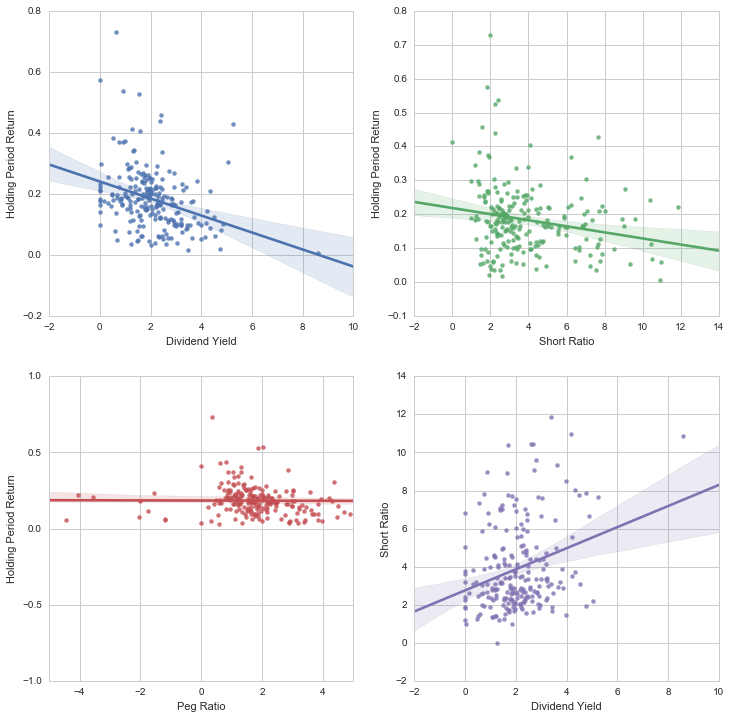

In [25]:
# Use the regplot to zoom in the graphs, I also did a linear regression with confidence interval 
fig, ax = plt.subplots(2,2,figsize = (12,12))
sns.regplot(x='Dividend Yield',y='Holding Period Return',data=sp_outperform,ax=ax[0,0], ci=95)
sns.regplot(x='Short Ratio',y='Holding Period Return',data=sp_outperform,ax=ax[0,1], ci=95)
sns.regplot(x='Peg Ratio',y='Holding Period Return',data=sp_outperform,ax=ax[1,0],ci=95)
ax[1,0].set_ylim([-1,1])
ax[1,0].set_xlim([-5,5])
sns.regplot(x='Dividend Yield',y='Short Ratio',data=sp_outperform,ax=ax[1,1], ci=95)

These four plot proves my thoughts in above. The Peg Ratio is not a good measure.And there is a negative correlation between dividend yield and return. All correlations are not strong so it is not satisfying.

Below I did a linear regression to model the relationship between the dividend yield and holding period return. Just to show the negative correlation coefficient.

In [26]:
# Load sklearn.linear_model to fit the linear regression and get the coefficients
from sklearn.linear_model import LinearRegression
splm = sp_outperform[['Holding Period Return','Dividend Yield' ]]
npmatrix = np.matrix(splm)
Y, X = npmatrix[:,0], npmatrix[:,1]
lreg = LinearRegression().fit(X,Y)
m = lreg.coef_[0]
c = lreg.intercept_
print('The formula of Model is: Holding Period Return = {0}*Dividend Yield + {1}'.format(m,c))

The formula of Model is: Holding Period Return = [-0.02793481]*Dividend Yield + [ 0.24026721]


### Exploring Moving Average 
Here, to identify whether the 50 days moving average is higher than 200days moving average in April 15,2017, I create a subset of spdi called spdi_MA. I create a new columns which contains booleans to signal the moving average relationship. True means 50 days moving average is higher than 200 days moving average. False means the opposite.

In [27]:
spdi_MA = spdi[['Sector','50 Days Moving Average', '200 Days Moving Average', 'Holding Period Return']].copy()    #copy the subset of spdi
spdi_MA['MA Signal'] = (spdi['50 Days Moving Average'] > spdi['200 Days Moving Average'])            # boolean selection as new column
spdi_MA.head()

,,Sector,50 Days Moving Average,200 Days Moving Average,Holding Period Return,MA Signal
Symbol,Name,,,,,
MMM,3M Company,Industrials,190.17,178.69,0.148554,True
ABT,Abbott Laboratories,Health Care,44.76,41.60,0.092702,True
ABBV,AbbVie,Health Care,64.69,62.20,0.136050,True
ACN,Accenture plc,Information Technology,121.49,118.87,-0.011021,True
ATVI,Activision Blizzard,Information Technology,48.50,42.49,0.136620,True


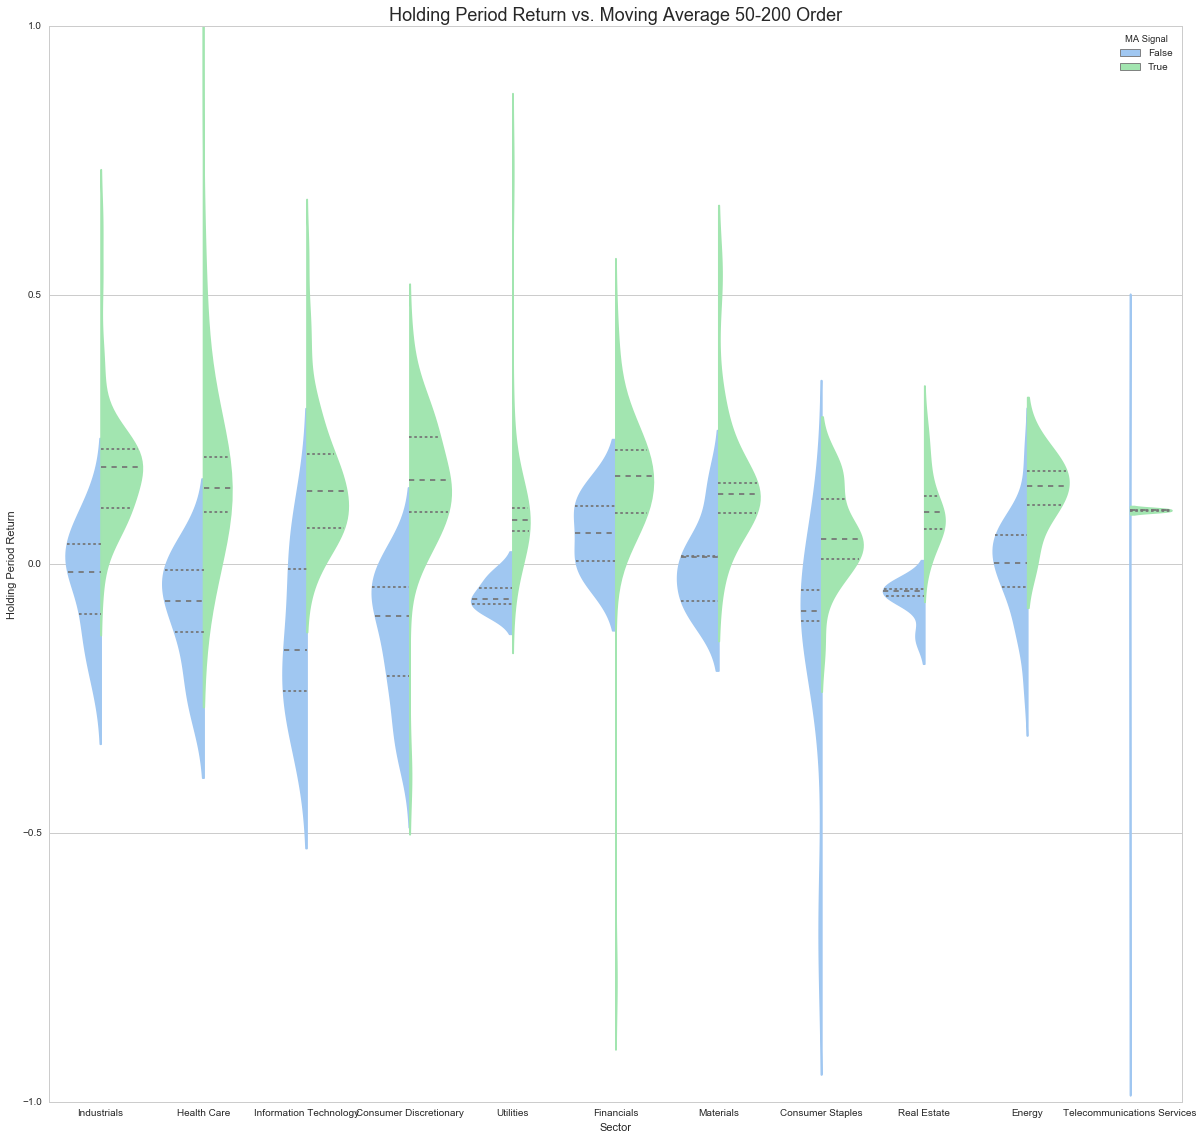

In [28]:
# Use the violinplot to plot the holding period return for each sectors. 
# Note that I use the hue function on 'MA signal'. so we get two pattern for stocks in each sectors.
sns.set(style="whitegrid", palette="pastel", color_codes=True)
fig, ax = plt.subplots(figsize=(17,16))
sns.violinplot(ax=ax, x= 'Sector', y ='Holding Period Return',hue='MA Signal', data = spdi_MA, edgecolor='gray', inner='quart', split=True)
ax.set_ylim([-1,1])
ax.set_title('Holding Period Return vs. Moving Average 50-200 Order', fontsize = 18)

fig.tight_layout()

### Comment:
Interestingly, whatever the sectors is, stocks with 50days moving average higher than 200days moving average always have higher average holding period return. So this is a good benchmark when picking the stocks.

Final thing I did in this part is to combine all ideas above to see if I could get a good portfolio of stocks which performed well in last half years. According to the correlation we should pick stocks with lower dividend yield, lower short ratio and stocks with 50days moving average higher than 200days moving average.

I do this by using the sort_value function so it could give me the stocks with lowest dividend yield as well as short ratio. I also use a boolean selection on spdi dataset to find stocks with 50days MA> 200days MA.

In [29]:
# I selected the top 10 stocks.
sp_top10 = spdi[spdi['50 Days Moving Average'] > spdi['200 Days Moving Average']].sort_values(['Dividend Yield', 'Short Ratio'],
                                                                                              ascending = True,
                                                                                              na_position='last').head(10)
sp_top10

,,Sector,50 Days Moving Average,200 Days Moving Average,Dividend Yield,Short Ratio,Peg Ratio,Stock price on 2016-11-1,Stock price on 2017-4-15,Holding Period Return,Sector Average Return
Symbol,Name,,,,,,,,,,
ETFC,E*Trade,Financials,34.86,33.70,0.0,1.19,1.68,28.100000,33.220001,0.182206,0.146524
MU,Micron Technology,Information Technology,26.46,21.85,0.0,1.83,6.25,16.980000,26.740000,0.574794,0.120163
ULTA,Ulta Salon Cosmetics & Fragrance Inc,Consumer Discretionary,281.43,262.30,0.0,1.87,1.70,240.179993,282.679993,0.176951,0.057711
ADBE,Adobe Systems Inc,Information Technology,124.94,112.64,0.0,2.25,2.03,106.870003,129.050003,0.207542,0.120163
ADSK,Autodesk Inc,Information Technology,85.69,78.79,0.0,3.60,-5.92,70.099998,84.910004,0.211270,0.120163
MYL,Mylan N.V.,Health Care,41.49,38.76,0.0,3.67,0.74,37.160000,37.669998,0.013724,0.157534
LH,Laboratory Corp. of America Holding,Health Care,142.97,134.29,0.0,3.75,1.65,123.830002,142.100006,0.147541,0.157534
UAL,United Continental Holdings,Industrials,70.70,67.50,0.0,3.79,-1.54,56.000000,69.070000,0.233393,0.138182
WAT,Waters Corporation,Health Care,155.67,147.07,0.0,4.53,2.64,137.429993,155.690002,0.132868,0.157534


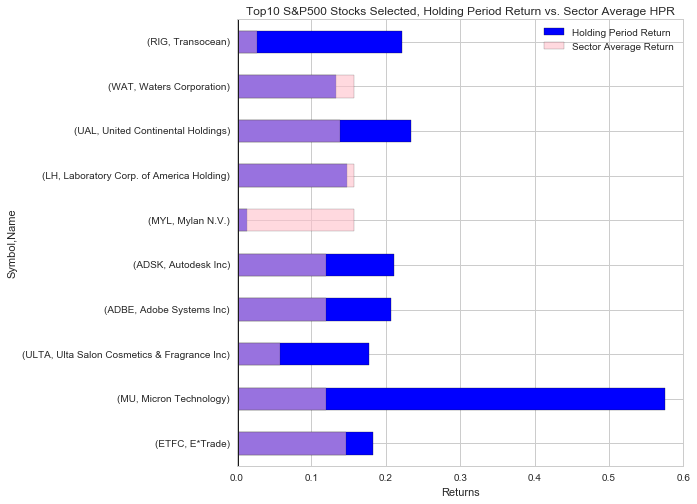

In [30]:
#plot their performance and their sector average performance
fig, ax = plt.subplots(figsize=(8, 8))
sp_top10.plot.barh(ax=ax, y="Holding Period Return", color="Blue")
sp_top10.plot.barh(ax=ax, y="Sector Average Return", color="Pink", alpha=0.6)
ax.vlines(0,-10,10, lw=3)
ax.set_title('Top10 S&P500 Stocks Selected, Holding Period Return vs. Sector Average HPR')
ax.set_xlabel('Returns')

** Conclusion:** It seems the portfolio is good. All stocks gain a positive return. 7 out of 10 stocks outperform their own sector. 8 out of 10 are stocks in hot sectors (Financials, Health Care, Industrials, Information Technology, Materials). I also get the stock with super return (57.5%) named Micron Technology. But the portfolio is also not perfect as the portfolio contains underperformer like Mylan N.V. 

# Trading Idea simulation
Below we examine two simple dynamic trading strategy. 

The first trading strategy is a brand-new idea, aiming to explore the relationship between the daily trading volume change and the daily return of the stocks. Before I do the simulation, I think the price of the stock should increase with an increasing trading volume in a up market because there are more demand. It turned out to be a failed attempt.

The second trading strategy is inspired by the idea above. I could long the stocks when the short-term moving average is higher than the long-term moving average and get the daily return. When opposite situation, I don't hold any position.(I don't consider shorting here because shorting is costly) Also, if we consider the closing price as a moving average of super short period, we could also use the relation between closing price and moving average as a decision factor.

### -First Trading Strategy - Volume Change based - Failed Attempt
Start by examine the relationship of daily volume change and daily return

In [31]:
# Get another timeseries data of stock, I used Apple stocks as an example('AAPL').
start = datetime.datetime(2016, 11, 1)
end = datetime.datetime(2017, 4, 15)
stock1 = web.DataReader('AAPL', 'yahoo', start, end)[['Close', 'Volume']]         #I only need Closing price and volume data
stock1.head()

,Close,Volume
Date,,
2016-11-01,111.489998,43825800
2016-11-02,111.589996,28331700
2016-11-03,109.830002,26932600
2016-11-04,108.839996,30837000
2016-11-07,110.410004,32560000


In [32]:
stock1['Previous Close'] = stock1.Close.shift(1)                        # Use the shift(1) method to shift 1 space of the volume and price
stock1['Previous Volume'] = stock1.Volume.shift(1)
stock1['Volume Change'] = np.log(stock1['Volume']/ stock1['Previous Volume'])  # Calculate the daily return and the daily volume change
stock1['Daily Return'] = np.log(stock1['Close']/ stock1['Previous Close'])     
# I express the daily return and volume change as log return, which is more convenient when I sum the return 
stock1.head()

,Close,Volume,Previous Close,Previous Volume,Volume Change,Daily Return
Date,,,,,,
2016-11-01,111.489998,43825800,NaN,NaN,NaN,NaN
2016-11-02,111.589996,28331700,111.489998,43825800.0,-0.436241,0.000897
2016-11-03,109.830002,26932600,111.589996,28331700.0,-0.050644,-0.015898
2016-11-04,108.839996,30837000,109.830002,26932600.0,0.135378,-0.009055
2016-11-07,110.410004,32560000,108.839996,30837000.0,0.054369,0.014322


In [33]:
# The scatter plot of volume change vs. Daily return, using plotly.
trace = go.Scatter(x = stock1['Volume Change'],
                   y = stock1['Daily Return'],
                   mode = 'markers'
                  )
layout = dict( title = 'Daily Volume Change vs. Price Change(Daily Return)',
              height = 600,
              width = 800,
             yaxis = dict(zeroline = True,
                         title = 'Daily Return'),
             xaxis = dict(zeroline=True,
                         title = 'Daily Volume Change')
             )
iplot(go.Figure(data=[trace], layout=layout))

The graph looks bad. I didn't discover any obvious correlations between the volume change and the return of stocks.

Below we do a statistical linear regression to see whether the two are correlated.

In [34]:
res = ols(y=stock1['Daily Return'], x=stock1['Volume Change'] )
res

D:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2847: FutureWarning:

The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://statsmodels.sourceforge.net/stable/regression.html




-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         112
Number of Degrees of Freedom:   2

R-squared:         0.0177
Adj R-squared:     0.0088

Rmse:              0.0097

F-stat (1, 110):     1.9807, p-value:     0.1621

Degrees of Freedom: model 1, resid 110

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x     0.0036     0.0025       1.41     0.1621    -0.0014     0.0085
     intercept     0.0021     0.0009       2.33     0.0215     0.0003     0.0039
---------------------------------End of Summary---------------------------------

The t-stat of coefficient and R-squared are not big enough. Though we get a positive correlaton， it is a weak and unreliable.

Still, I still want to examine the return of strategy, that is, the return that one long the stock when volume increase and don't hold any position when volume decrease. Below are the test of the example stock.

In [35]:
print('The strategy return is' ,stock1[stock1['Volume Change']>0]['Daily Return'].sum())
print('The market return is' , stock1['Daily Return'].sum())        #    

The strategy return is 0.19610995750258634
The market return is 0.235179575876408


I get a smaller return than the market return. It means the strategy failed on the sample. Below, I use the first 20 stocks as sample to test again my first strategy.

In [36]:
# define functions which could get the strategy return and the market return of a stock by inputting the symbol
# The function basically use the same procedure I did for Apple stocks.
def strategy1_return(stock):
    start = datetime.datetime(2016, 11, 1)
    end = datetime.datetime(2017, 4, 15)
    stock1 = web.DataReader(stock, 'yahoo', start, end)
    stock1 = stock1[['Close', 'Volume']]
    stock1['Previous Close'] = stock1.Close.shift(1)
    stock1['Previous Volume'] = stock1.Volume.shift(1)
    stock1['Volume Change'] = np.log(stock1['Volume']/ stock1['Previous Volume'])
    stock1['Daily Return'] = np.log(stock1['Close']/ stock1['Previous Close'])
    return stock1[stock1['Volume Change']>0]['Daily Return'].sum()

def market_return(stock):
    start = datetime.datetime(2016, 11, 1)
    end = datetime.datetime(2017, 4, 15)
    stock1 = web.DataReader(stock, 'yahoo', start, end)
    stock1 = stock1[['Close', 'Volume']]
    stock1['Previous Close'] = stock1.Close.shift(1)
    stock1['Previous Volume'] = stock1.Volume.shift(1)
    stock1['Volume Change'] = np.log(stock1['Volume']/ stock1['Previous Volume'])
    stock1['Daily Return'] = np.log(stock1['Close']/ stock1['Previous Close'])
    return stock1['Daily Return'].sum()
# to insure that my functions are right, print out the returns for apple stocks.
print('The strategy return is', strategy1_return('AAPL'))
print('The market return is', market_return('AAPL'))

The strategy return is 0.19610995750258634
The market return is 0.235179575876408


In [37]:
# get the symbol_list from the spdi dataset
symbol_list = list(spdi.reset_index()['Symbol'].astype(str))
# build two list to contains returns for strategy return and market return. It might takes a while to finish running since there are 20 stocks.
lists1 = []
listm1 = []
for symbol in symbol_list[0:20]:
    lists1.append(strategy1_return(symbol))                        # for each stock symbol get the strategy return and add it into the list
    listm1.append(market_return(symbol))                        # for each stock symbol get the market return and add it into the list

In [38]:
# create new data frame for this strategy in order to plot
strategy1 = pd.DataFrame({'Strategy Return': lists1,
                         'Market Return': listm1},
                        index = symbol_list[0:20])
strategy1.head(3)

,Market Return,Strategy Return
MMM,0.138504,0.069809
ABT,0.088653,-0.079367
ABBV,0.127557,0.063072


In [39]:
# use plotly to plot the bar chart of market return vs. strategy return
mr = dict(type = 'bar',
          name = 'Market Return',
          y = strategy1['Market Return'],
          x = strategy1.index,
          marker = dict(color = 'rgb(200,200,200)'),
          opacity=0.4
        )
sr = dict(type = 'bar',
          name = 'Strategy Return',
          y = strategy1['Strategy Return'],
          x = strategy1.index,
          marker = dict(color = 'rgb(100,10,100)'),
          opacity = 0.4
         )
layout = dict(width=850, height=500,                        
              yaxis={'title': 'Return'},                    
              title='Market Return vs. Strategy Return',            
              xaxis={'title': 'Sample Company Symbol'}
         )
iplot(go.Figure(data=[mr,sr], layout=layout))

#### Comment:
Obviously , the first strategy failed because it can not insure us to get better return than the market. There are lots of stocks in the chart underperforming the market. 

### -Second Trading Strategy - Moving Average Based - Success

To restate the idea, the trader long the stocks when the short term moving average is higher than the long term moving average. Specifically, I long the stock when the stock price (super short term moving average) is greater than 5 days moving average, and the 5 days moving average is greater than the 20days moving average. I pick the 5 days and 20days simply because our testing period is only half years. One can test the 50days and 200days for longer period.

In [40]:
# Get another timeseries data of stock, still used Apple stocks as an example('AAPL').
start = datetime.datetime(2016, 11, 1)
end = datetime.datetime(2017, 4, 15)
stock2 = web.DataReader('AAPL', 'yahoo', start, end)[['Close']]         #This time I only need  closing price  
stock2.head()

,Close
Date,
2016-11-01,111.489998
2016-11-02,111.589996
2016-11-03,109.830002
2016-11-04,108.839996
2016-11-07,110.410004


In [41]:
# Calculate the 5/20 days moving average using the rolling method. 
stock2['5 Days Moving Average'] = stock2['Close'].rolling(window=5).mean()         
stock2['20 Days Moving Average'] = stock2['Close'].rolling(window=20).mean()
stock2['Previous Close'] = stock2.Close.shift(1)
stock2['Daily Return'] = np.log(stock2['Close']/ stock2['Previous Close'])      #Similar to the first strategy, calculate daily log return
stock3 = stock2.dropna(axis = 0, how='any') #drop several nan data in the beginning caused by rolling function, create a new dataset stock3
stock3.head()                         # The new timeseries data begin on November 29,2016

,Close,5 Days Moving Average,20 Days Moving Average,Previous Close,Daily Return
Date,,,,,
2016-11-29,111.459999,111.570001,110.1360,111.570000,-0.000986
2016-11-30,110.519997,111.314000,110.0875,111.459999,-0.008469
2016-12-01,109.489998,110.965999,109.9825,110.519997,-0.009363
2016-12-02,109.900002,110.587999,109.9860,109.489998,0.003738
2016-12-05,109.110001,110.095999,109.9995,109.900002,-0.007214


In [42]:
# time series plot of closing price and 5/20 days moving average, plotly
close = go.Scatter(
                x=stock3.index,
                y=stock3['Close'] ,
                name = 'Closing Price',
                line = dict(color = 'black'),
                opacity = 0.8)
MA5 = go.Scatter(
                x=stock3.index,
                y=stock3['5 Days Moving Average'] ,
                name = '5 Days Moving Average',
                line = dict(color = 'rgb(0,125,255)'),
                opacity = 0.8)

MA20 = go.Scatter(
                x=stock3.index,
                y=stock3['20 Days Moving Average'],
                name = '20 Days Moving Average',
                line = dict(color = 'rgb(255,0,0)'),
                opacity = 0.8)


layout = dict(
    title = 'Time Series Plot of Stock Price and 5/20 Days Moving Average',
    yaxis={'title': 'Price'},
    xaxis={'title': 'Date'}
)

iplot(dict(data=[close,MA5, MA20], layout=layout))

In [43]:
# Here we define our benchmark for longing the stock, and similarly we calculate our new strategy return and market return
benchmark = (stock3['5 Days Moving Average'] > stock3['20 Days Moving Average']) | (stock3['Close']> stock3['5 Days Moving Average'])
print('The strategy return is', stock3[benchmark]['Daily Return'].sum())
print('The market return is', stock3['Daily Return'].sum())

The strategy return is 0.23976543864949776
The market return is 0.23446226211197094


In [44]:
# similarly, we define another two function for the second strategy
def strategy2_return(stock):
    start = datetime.datetime(2016, 11, 1)
    end = datetime.datetime(2017, 4, 15)
    stock2 = web.DataReader(stock, 'yahoo', start, end)[['Close']]
    stock2['5 Days Moving Average'] = stock2['Close'].rolling(window=5).mean()
    stock2['20 Days Moving Average'] = stock2['Close'].rolling(window=20).mean()
    stock2['Previous Close'] = stock2.Close.shift(1)
    stock2['Daily Return'] = np.log(stock2['Close']/ stock2['Previous Close'])
    stock3 = stock2.dropna(axis = 0, how='any')
    benchmark = (stock3['5 Days Moving Average'] > stock3['20 Days Moving Average']) | (stock3['Close']> stock3['5 Days Moving Average'])
    return stock3[benchmark]['Daily Return'].sum()

def market2_return(stock):
    start = datetime.datetime(2016, 11, 1)
    end = datetime.datetime(2017, 4, 15)
    stock2 = web.DataReader(stock, 'yahoo', start, end)[['Close']]
    stock2['5 Days Moving Average'] = stock2['Close'].rolling(window=5).mean()
    stock2['20 Days Moving Average'] = stock2['Close'].rolling(window=20).mean()
    stock2['Previous Close'] = stock2.Close.shift(1)
    stock2['Daily Return'] = np.log(stock2['Close']/ stock2['Previous Close'])
    stock3 = stock2.dropna(axis = 0, how='any')
    benchmark = (stock3['5 Days Moving Average'] > stock3['20 Days Moving Average']) | (stock3['Close']> stock3['5 Days Moving Average'])
    return stock3['Daily Return'].sum()
# to insure that my functions are right, print out the returns for apple stocks.
print('The strategy return is', strategy2_return('AAPL'))
print('The market return is', market2_return('AAPL'))

The strategy return is 0.23976543864949776
The market return is 0.23446226211197094


Steps below are quite similar to the first strategy, I use the symbol_list I derived in the first trading strategy simulation.

In [45]:
lists2=[]
listm2=[]
# build two list to contains returns for strategy return and market return. It might takes a while to finish running since there are 20 stocks.
for symbol in symbol_list[0:20]:
    lists2.append(strategy2_return(symbol))
    listm2.append(market2_return(symbol))

In [46]:
# create new data frame for this strategy in order to plot
strategy2 = pd.DataFrame({'Strategy Return': lists2,
                         'Market Return': listm2},
                        index = symbol_list[0:20])
strategy2.head(3)

,Market Return,Strategy Return
MMM,0.089496,0.135675
ABT,0.096623,0.186077
ABBV,0.075608,0.193142


In [47]:
mr2 = dict(type = 'bar',
          name = 'Market Return',
          y = strategy2['Market Return'],
          x = strategy2.index,
          marker = dict(color = 'rgb(200,200,200)'),
          opacity=0.4
        )
sr2 = dict(type = 'bar',
          name = 'Moving Average Strategy Return',
          y = strategy2['Strategy Return'],
          x = strategy2.index,
          marker = dict(color = 'rgb(100,10,100)'),
          opacity = 0.4
         )
layout = dict(width=850, height=500,                        
              yaxis={'title': 'Return'},                    
              title='Market Return vs. Moving Average Strategy Return',            
              xaxis={'title': 'Sample Company Symbol'}
         )
iplot(go.Figure(data=[mr2,sr2], layout=layout))

#### Comment:
We get a great plot! All the stocks we used in the graph get possitive returns by using our second strategy based on moving average. Also, they outperform the market return. Some (such as AYI, AAP) even get a positive return when the market return is negative.

In reality, there are some difficulties to use this strategy. One problem is, there is always a lag between the time you discover the pattern of the moving average (stock price> 5days MA> 20 days MA) and the time when you build your position. So in real life the return would be lower than the return I get above. 

## Summary

All in all, the exploration is meaningful. Though there are some failures like PEG ratio and volume based trading strategy. I get some valuable discovery in this notebook. For a trader or investor, it might be better to pick stocks in hot sectors. One should be aware of the meaningful correlations between the short ratio and return, the dividend yield and return. One could also take advantage of the moving average order, as I showed both in the analysis part and trading simulation part. 

Thanks for reading!